# **Importação e instalação das bibliotecas**

In [ ]:
#instalação da biblioteca- versão 2.2.3
!pip install -q spacy==2.2.3

In [ ]:
#download do pacote em portugues para processamento dos textos
!python3 -m spacy download pt

In [10]:
import spacy
#verificando a versão 
spacy.__version__

'2.2.3'

In [ ]:
!pip install --user -U nltk

In [ ]:
!pip install -U textblob

In [34]:
import numpy as np 
import pandas as pd 
from os import path
import spacy
import re
import string
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from textblob import TextBlob

#  Carregamento das bases de dados

In [14]:
cmt = pd.read_csv("/content/df.csv")

cmt.head()

,Unnamed: 0,Name,Comment,Time,Likes,Reply Count
0,0,Name,Comment,Time,Likes,Reply Count
1,1,Metrópoles,ASSISTA TAMBÉM: Leo Dias entrevista Eduardo Al...,2022-03-24T15:23:51Z,16,6
2,2,Luiza Neves,"*Que o desempregado consiga um emprego, que o ...",2022-03-24T15:31:08Z,0,NaN
3,3,Luiza Neves,"*Que o desempregado consiga um emprego, que o ...",2022-03-24T15:31:04Z,0,NaN
4,4,Luiza Neves,"*Que o desempregado consiga um emprego, que o ...",2022-03-24T15:30:58Z,0,NaN


In [15]:
cmt.dtypes

Unnamed: 0      int64
Name           object
Comment        object
Time           object
Likes          object
Reply Count    object
dtype: object

In [16]:
cmt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15148 entries, 0 to 15147
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   15148 non-null  int64 
 1   Name         15147 non-null  object
 2   Comment      15147 non-null  object
 3   Time         15148 non-null  object
 4   Likes        15148 non-null  object
 5   Reply Count  10042 non-null  object
dtypes: int64(1), object(5)
memory usage: 710.2+ KB


In [18]:
#removendo columa name = nome dos usuários
cmt = cmt.drop(columns=['Name'])
cmt.head()

,Unnamed: 0,Comment,Time,Likes,Reply Count
0,0,Comment,Time,Likes,Reply Count
1,1,ASSISTA TAMBÉM: Leo Dias entrevista Eduardo Al...,2022-03-24T15:23:51Z,16,6
2,2,"*Que o desempregado consiga um emprego, que o ...",2022-03-24T15:31:08Z,0,NaN
3,3,"*Que o desempregado consiga um emprego, que o ...",2022-03-24T15:31:04Z,0,NaN
4,4,"*Que o desempregado consiga um emprego, que o ...",2022-03-24T15:30:58Z,0,NaN


In [20]:
#removendo a coluna Unnamed
cmt = cmt.drop(columns=['Unnamed: 0'])
cmt.head()

,Comment,Time,Likes,Reply Count
0,Comment,Time,Likes,Reply Count
1,ASSISTA TAMBÉM: Leo Dias entrevista Eduardo Al...,2022-03-24T15:23:51Z,16,6
2,"*Que o desempregado consiga um emprego, que o ...",2022-03-24T15:31:08Z,0,NaN
3,"*Que o desempregado consiga um emprego, que o ...",2022-03-24T15:31:04Z,0,NaN
4,"*Que o desempregado consiga um emprego, que o ...",2022-03-24T15:30:58Z,0,NaN


In [21]:
#resumo descritivo dos dados
cmt.describe().T

,count,unique,top,freq
Comment,15147,14618,Kkkkkkk,24
Time,15148,11374,2022-03-24T14:26:05Z,6
Likes,15148,203,0,9932
Reply Count,10042,54,0,8997


In [22]:
#verificando valores nulos nos comentários e avaliações 
_ = cmt.isnull().sum().to_frame().reset_index()
_.columns = ['index', 'valores_nulos']
_['proporção'] = [round(_['valores_nulos'][x]/len(cmt)*100,2) for x in list(range(len(_)))]

print(f'Total da amostra: {len(cmt)}')

print(f'\nVerificando valores nulos:')
_

Total da amostra: 15148

Verificando valores nulos:


,index,valores_nulos,proporção
0,Comment,1,0.01
1,Time,0,0.00
2,Likes,0,0.00
3,Reply Count,5106,33.71


In [24]:
# dropando comentarios sem comentário
cmt = cmt[cmt['Comment'].notna()]
cmt.head(5)

,Comment,Time,Likes,Reply Count
0,Comment,Time,Likes,Reply Count
1,ASSISTA TAMBÉM: Leo Dias entrevista Eduardo Al...,2022-03-24T15:23:51Z,16,6
2,"*Que o desempregado consiga um emprego, que o ...",2022-03-24T15:31:08Z,0,NaN
3,"*Que o desempregado consiga um emprego, que o ...",2022-03-24T15:31:04Z,0,NaN
4,"*Que o desempregado consiga um emprego, que o ...",2022-03-24T15:30:58Z,0,NaN


# **Função para pré-processamento dos comentários**


* Nome do usuário (@)
* URLs
* Espaços em branco
* Emoticons
* Stop words
* Lematização
* Pontuações

Aqui vamos usar a spaCy, uma biblioteca  de NLP para processamento de dados textuais nesse caso, usaremos para lematização e remover stopwords

In [25]:
pln = spacy.load('pt')
pln

In [26]:
stop_words = spacy.lang.pt.stop_words.STOP_WORDS

In [38]:
def preprocessamento(texto):
  # Letras minúsculas
  texto = texto.lower()

  # Nome do usuário
  texto = re.sub(r"@[A-Za-z0-9$-_@.&+]+", ' ', texto)

  # URLs
  texto = re.sub(r"https?://[A-Za-z0-9./]+", ' ', texto)

  # Espaços em branco
  texto = re.sub(r" +", ' ', texto)


  # Lematização
  documento = pln(texto)

  lista = []
  for token in documento:
    lista.append(token.lemma_)
  
  # Stop words e pontuações
  lista = [palavra for palavra in lista if palavra not in stop_words and palavra not in string.punctuation]
  lista = ' '.join([str(elemento) for elemento in lista if not elemento.isdigit()])
  
  return lista

In [39]:
#aplicando a função de pre processamento de textos
cmt['Comment'] = cmt['Comment'].apply(preprocessamento)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [42]:
#aplicando a função do textBlob para atribuir polaridade e subjetividade nos textos
cmt['polaridade'] = cmt.Comment.apply(lambda x: TextBlob(x).polarity)
cmt['subjetividade'] = cmt.Comment.apply(lambda x: TextBlob(x).subjectivity)

cmt.head(5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Comment,Time,Likes,Reply Count,polaridade,subjetividade
0,comment,Time,Likes,Reply Count,0.0,0.0
1,assistir leo dia entrevisto eduardo alves pers...,2022-03-24T15:23:51Z,16,6,0.0,0.3
2,o desempregar conseguir empregar o doente cura...,2022-03-24T15:31:08Z,0,NaN,0.0,0.0
3,o desempregar conseguir empregar o doente cura...,2022-03-24T15:31:04Z,0,NaN,0.0,0.0
4,o desempregar conseguir empregar o doente cura...,2022-03-24T15:30:58Z,0,NaN,0.0,0.0


In [44]:
#classificação de sentimento positivo , negativo e neutro
cmt['sentimento'] = np.where(cmt.polaridade > 0, 'positivo', 
                                 np.where(cmt.polaridade < 0, 'negativo', 'neutro'))
cmt.head(5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Comment,Time,Likes,Reply Count,polaridade,subjetividade,sentimento
0,comment,Time,Likes,Reply Count,0.0,0.0,neutro
1,assistir leo dia entrevisto eduardo alves pers...,2022-03-24T15:23:51Z,16,6,0.0,0.3,neutro
2,o desempregar conseguir empregar o doente cura...,2022-03-24T15:31:08Z,0,NaN,0.0,0.0,neutro
3,o desempregar conseguir empregar o doente cura...,2022-03-24T15:31:04Z,0,NaN,0.0,0.0,neutro
4,o desempregar conseguir empregar o doente cura...,2022-03-24T15:30:58Z,0,NaN,0.0,0.0,neutro


In [45]:
# Mostra os 5 principais comentários com maior pontuação de polaridade
cmt.nlargest(5,'polaridade')['Comment']


1385    o vezar o pessoa o ruir analfabeto pessoa estu...
2790                                    o romântico 🎵 ♥ ️
6720      íse 💄 ♥ ️ o mulherada cair labia q aleatório...
6726         íse 💄 ♥ ️ achar cheio transtorno psicológico
9123    sortir apelidar o verdadeiro nome sucesso cham...
Name: Comment, dtype: object

In [46]:
# Mostra os 5 principais comentarios com maiores pontuações de polaridade e subjetividade
cmt.nlargest(5, ['polaridade', 'subjetividade'])['Comment']

1385    o vezar o pessoa o ruir analfabeto pessoa estu...
2790                                    o romântico 🎵 ♥ ️
6720      íse 💄 ♥ ️ o mulherada cair labia q aleatório...
6726         íse 💄 ♥ ️ achar cheio transtorno psicológico
9123    sortir apelidar o verdadeiro nome sucesso cham...
Name: Comment, dtype: object

In [47]:
# Mostra os 5 principaiscomentarios com pontuações de polaridade mais baixas
cmt.nsmallest(5,'polaridade')['Comment']

2375     pq o surpreso algum pessoa alguém elogiar o ca...
11343      almeida poxa ... lamentar verdade vc pé e re...
13701    esperar o pessoa condição ajudar o o arrumar \...
3107     mendigão patriota sentar o mandioca o bombrilz...
4223     geleiou o mendigar mendigopill labiapill bruta...
Name: Comment, dtype: object

In [48]:
#Mostra os 5 principais comentáriis com menor pontuação de polaridade e subjetividade
cmt.nsmallest(5, ['polaridade', 'subjetividade'])['Comment']

2375     pq o surpreso algum pessoa alguém elogiar o ca...
11343      almeida poxa ... lamentar verdade vc pé e re...
13701    esperar o pessoa condição ajudar o o arrumar \...
3107     mendigão patriota sentar o mandioca o bombrilz...
4223     geleiou o mendigar mendigopill labiapill bruta...
Name: Comment, dtype: object

# **Análise exploratoria dos sentimentos**

In [49]:
cmt['sentimento'].value_counts()

neutro      14304
positivo      646
negativo      197
Name: sentimento, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


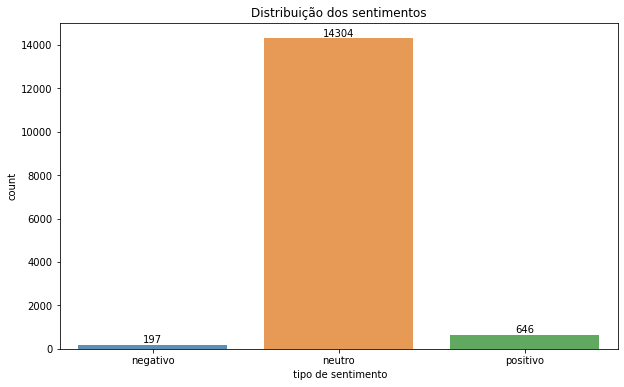

In [50]:
x=cmt['sentimento'].value_counts()
x=x.sort_index()
plt.figure(figsize=(10,6))
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("Distribuição dos sentimentos")
plt.ylabel('count')
plt.xlabel(' tipo de sentimento')
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
plt.show();

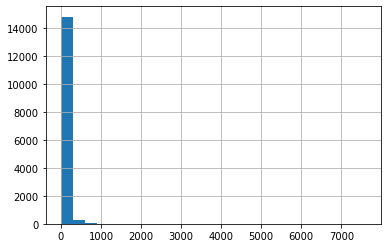

In [56]:
# Vamos ver o comprimento dos comentários
comp = [len(i) for i in cmt['Comment']]

pd.Series(comp).hist(bins = 25)

In [51]:
from sklearn.preprocessing import LabelBinarizer


lb = LabelBinarizer()

sentbinarized = lb.fit_transform(cmt['sentimento']).tolist()

dfbinarized = pd.DataFrame(sentbinarized, columns=lb.classes_)
cmt[dfbinarized.columns] = dfbinarized
cmt.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,Comment,Time,Likes,Reply Count,polaridade,subjetividade,sentimento,negativo,neutro,positivo
0,comment,Time,Likes,Reply Count,0.0,0.0,neutro,0.0,1.0,0.0
1,assistir leo dia entrevisto eduardo alves pers...,2022-03-24T15:23:51Z,16,6,0.0,0.3,neutro,0.0,1.0,0.0
2,o desempregar conseguir empregar o doente cura...,2022-03-24T15:31:08Z,0,NaN,0.0,0.0,neutro,0.0,1.0,0.0
3,o desempregar conseguir empregar o doente cura...,2022-03-24T15:31:04Z,0,NaN,0.0,0.0,neutro,0.0,1.0,0.0
4,o desempregar conseguir empregar o doente cura...,2022-03-24T15:30:58Z,0,NaN,0.0,0.0,neutro,0.0,1.0,0.0


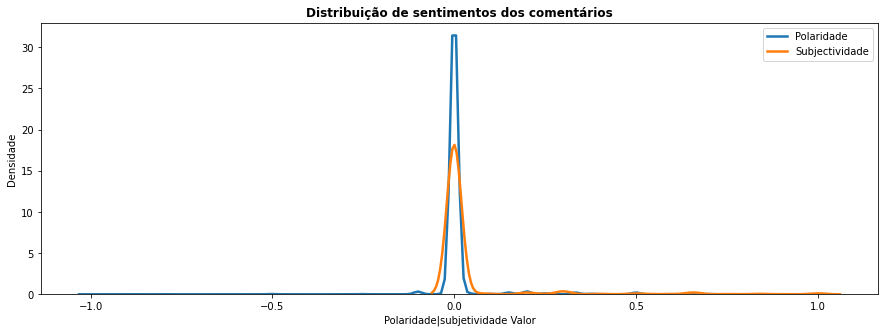

In [52]:
plt.figure(figsize=(15,5))
plt.title('Distribuição de sentimentos dos comentários',fontsize=12,fontweight='bold')
sns.kdeplot(cmt['polaridade'], label='Polaridade', lw=2.5)
sns.kdeplot(cmt['subjetividade'], label='Subjectividade', lw=2.5)
plt.xlabel('Polaridade|subjetividade Valor', fontsize=10)
plt.ylabel('Densidade', fontsize=10)
plt.legend()
plt.show()

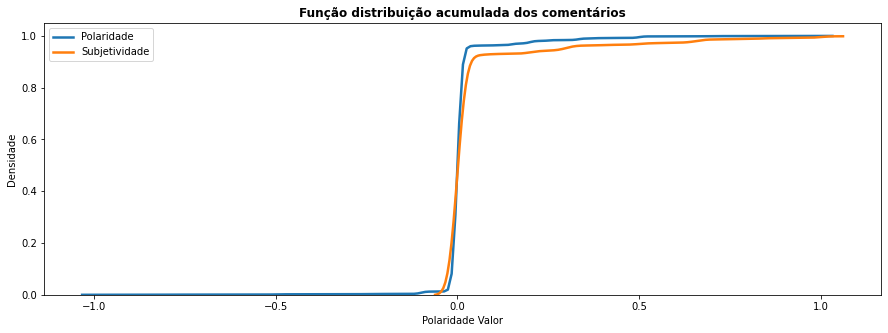

In [53]:
plt.figure(figsize=(15,5))
plt.title('Função distribuição acumulada dos comentários',fontsize=12, fontweight='bold')
sns.kdeplot(cmt['polaridade'],cumulative=True, label='Polaridade',lw=2.5)
sns.kdeplot(cmt['subjetividade'],cumulative=True, label='Subjetividade',lw=2.5)
plt.xlabel('Polaridade Valor', fontsize=10)
plt.ylabel('Densidade', fontsize=10)
plt.legend()
plt.show()

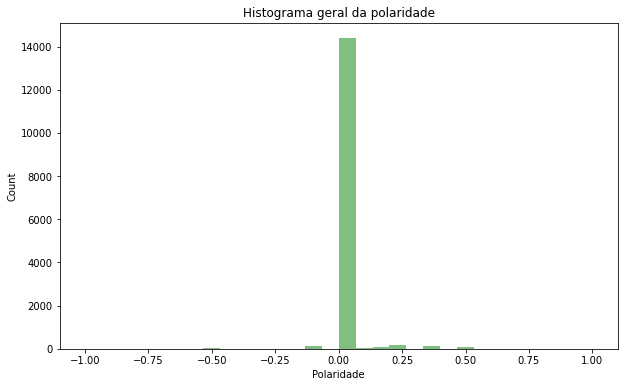

In [55]:
num_bins = 30
plt.figure(figsize=(10,6))
n, bins, patches = plt.hist(cmt.polaridade, num_bins, facecolor='green', alpha=0.5)
plt.xlabel('Polaridade')
plt.ylabel('Count')
plt.title('Histograma geral da polaridade')
plt.show();

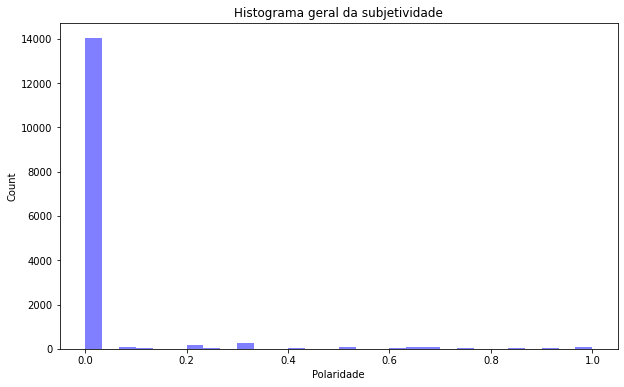

In [58]:
num_bins = 30
plt.figure(figsize=(10,6))
n, bins, patches = plt.hist(cmt.subjetividade, num_bins, facecolor='blue', alpha=0.5)
plt.xlabel('Polaridade')
plt.ylabel('Count')
plt.title('Histograma geral da subjetividade')
plt.show();

**Referências**

https://www.kaggle.com/code/lvalencia/data-exploration-and-textblob-sentiment-analysis/notebook

https://textblob.readthedocs.io/en/dev/quickstart.html